**Dataset**: https://www.nature.com/articles/s41597-024-03237-9

**Encoder and Decoder Reference**: https://www.youtube.com/watch?v=U0s0f995w14

**user ID** is the unique identifier of the mobile phone user (type: integer)

**day** is the masked date of the observation. It may take a value between 0 and 74 for both Dataset 1 and Dataset 2 (type: integer).

The location pings are discretized into 500 meters × 500 meters grid cells and the timestamps are rounded up into 30-minute bins. The actual date of the observations is not available either (i.e., timeslot t of day d) to protect privacy. In the second Dataset, the 75 day period is composed of 60 days of business-as-usual and 15 days during an emergency with unusual behavior.

**timeslot** is the timestamp of the observation discretized into 30 minute intervals. 
It may take a value between 0 and 47, where 0 indicates between 0AM and 0:30AM, 
and 13 would indicate the timeslot between 6:30AM and 7:00AM.

**x,y** are the coordinates of the observed location mapped onto the 500 meter discretized grid cell. It may take a value between (1, 1) and (200, 200). Details are shown in Fig. 2.

# Import Libraries

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

## Input Data Processing + Tokenization

In [2]:
# yjmob1 = 'yjmob100k-dataset1.csv.gz'
# yjmob2 = 'yjmob100k-dataset2.csv.gz'
# yjmob_df = pd.concat([pd.read_csv(yjmob1, compression='gzip'),
#                       pd.read_csv(yjmob2, compression='gzip')]).sort_values(by=['uid','d','t'],
#                                                                             ignore_index=True)

In [3]:
yjmob1 = 'yjmob100k-dataset1.csv.gz' # dataset under normal scenes
yjmob_df = pd.read_csv(yjmob1, compression='gzip').sort_values(by=['uid', 'd', 't'], ignore_index=True)

### Train-Val-Test Split

In [4]:
# Retrieve all ids

uids = yjmob_df['uid'].unique()

In [5]:
# Just to reduce memory space

selected_uids = uids[:200]

In [6]:
# 70 : 15 : 15 split

# test-train split
train_val_uids, test_uids = train_test_split(selected_uids, test_size=0.15, random_state=42)

# validation-test split
train_uids, val_uids = train_test_split(train_val_uids, test_size=0.176, random_state=42) # 0.176≈15/85

### Load Test Data

In [7]:
df = yjmob_df[yjmob_df['uid'].isin(test_uids)]

In [8]:
df.head(5)

,uid,d,t,x,y
22766,15,0,14,72,85
22767,15,0,15,66,82
22768,15,0,19,63,79
22769,15,0,20,69,74
22770,15,0,21,69,75


### Tokenize Time Data

In [9]:
# df[['t']].min(), df[['t']].max() # [0, 47]
# df[['d']].min(), df[['d']].max() # [0, 74]

In [10]:
df['combined_t'] = df['d']*47+df['t']

## Ignore the SettingWithCopyWarning

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_73551/4212691307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_t'] = df['d']*47+df['t']


In [11]:
df.head(5)

,uid,d,t,x,y,combined_t
22766,15,0,14,72,85,14
22767,15,0,15,66,82,15
22768,15,0,19,63,79,19
22769,15,0,20,69,74,20
22770,15,0,21,69,75,21


### Tokenize Spatial Data

In [12]:
# linearization of the 2-dimensional grid, i.e., the original x,y coordinate system
def spatial_token(x, y):
    # x,y are the coordinate location
    # x determines the column order while
    # y determines the row order
    # (x-1) calculates the starting grid-column position
    # (y-1)*200 calculates the start index of the grid-row
    return (x-1)+(y-1)*200

In [13]:
df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

## Ignore the SettingWithCopyWarning

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_73551/424670490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)


In [14]:
df.head(5)

,uid,d,t,x,y,combined_t,combined_xy
22766,15,0,14,72,85,14,16871
22767,15,0,15,66,82,15,16265
22768,15,0,19,63,79,19,15662
22769,15,0,20,69,74,20,14668
22770,15,0,21,69,75,21,14868


In [15]:
# original data

# df['combined_t'].min(), df['combined_t'].max() # (0, 3525)
# df['combined_xy'].min(), df['combined_xy'].max() # (0, 39999)

df = df.sort_values(by=['uid', 'combined_t'])

In [16]:
df.head(5)

,uid,d,t,x,y,combined_t,combined_xy
22766,15,0,14,72,85,14,16871
22767,15,0,15,66,82,15,16265
22768,15,0,19,63,79,19,15662
22769,15,0,20,69,74,20,14668
22770,15,0,21,69,75,21,14868


## Batching

In [23]:
# Output input location sequence (trajectory), desired output location
# along with the time when that user reaches a location

# # Sliding Window Approach
# def generate_sequences(data, data_t, window_size):
#     inputs = []
#     labels = []
#     positions = []
#     label_positions = []
#     for i in range(len(data) - window_size):
#         sequence = data[i:i + window_size]
#         label = data[i + window_size]
#         time_sequence = data_t[i:i + window_size]
#         label_time = data_t[i + window_size]

#         inputs.append(sequence)
#         labels.append(label)
#         positions.append(time_sequence)
#         label_positions.append(label_time)
#     return inputs, labels, positions, label_positions

def generate_sequences(data, data_t):
    # return torch.tensor(data[:-1]), torch.tensor(data[-1]), torch.tensor(data_t[:-1]), torch.tensor(data_t[-1])
    return torch.tensor(data[:10]), torch.tensor(data[10]), torch.tensor(data_t[:10]), torch.tensor(data_t[10])

In [24]:
# WINDOW_SIZE = 500 # 500 locations as one trajectory
BATCH_SIZE = 50   # 50 users at a batch

In [25]:
# Group data by uid

grouped_data = df[['uid', 'combined_t', 'combined_xy']].groupby('uid')
grouped_data = [group for _, group in df.groupby('uid')]

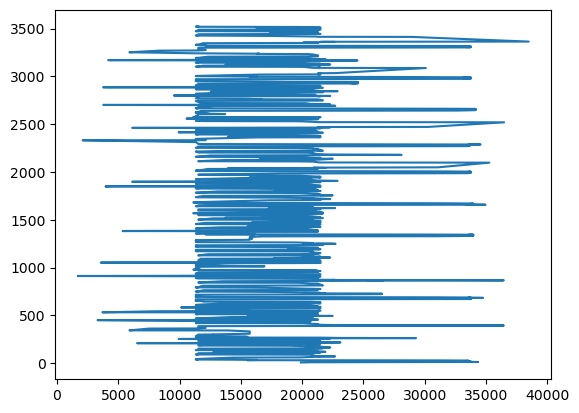

In [26]:
x = grouped_data[1]['combined_xy']
y = grouped_data[1]['combined_t']

plt.plot(x, y)

In [27]:
class TrajectoryDataset(Dataset):
    # def __init__(self, grouped_data, window_size):
    def __init__(self, grouped_data):
        self.data = grouped_data
        # self.window_size = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_for_uid = self.data[idx]
        inputs, labels, positions, label_positions = generate_sequences(
                                                         data_for_uid['combined_xy'].values.tolist(),
                                                         data_for_uid['combined_t'].values.tolist())
        return inputs, labels, positions, label_positions
                                                         # self.window_size)
        # TODO: Only first 500 trajectories for all users are extracted for now
        # To fix this I think the whole dataset needs to be restructured
        # ,regardless of the uid, i.e. just pay attention to the movement of any arbitrary user
        # like the first 500 movement of an arbitray user would be in the same mid (movement id)
        # but what is the point of using positional embedding if this is the case
        # because basically, you are focus only on the movement of the user
        # so...should LSTM work better in terms of its speed and simplicity
        # and having a similar purpose as the Transformer?
        # return torch.tensor(inputs[0]), torch.tensor(labels[0]), \
                # torch.tensor(positions[0]), torch.tensor(label_positions[0])

test_dataset = TrajectoryDataset(grouped_data) # WINDOW_SIZE

In [28]:
# Example
test_dataset.__getitem__(0) # uid=23, inputs, labels, positions, label_positions

(tensor([16871, 16265, 15662, 14668, 14868, 14864, 15067, 14668, 14670, 14470]),
 tensor(14470),
 tensor([14, 15, 19, 20, 21, 22, 23, 24, 25, 26]),
 tensor(27))

In [29]:
def collate_fn(batch):
    """
    batch: Dataset
    """
    # Unzip all batch
    inputs_batch, labels_batch, positions_batch, label_positions_batch = zip(*batch)
    
    # Pad the sequence with less length in a batch
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs_batch, padding_value=0.0, batch_first=True)
    labels_padded = torch.tensor(np.array(labels_batch))
    positions_padded = torch.nn.utils.rnn.pad_sequence(positions_batch, padding_value=0, batch_first=True)
    label_positions_padded = torch.tensor(np.array(label_positions_batch))
    
    return inputs_padded, labels_padded, positions_padded, label_positions_padded

In [30]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [31]:
# Example

data_iter = iter(test_dataloader)
inputs, labels, positions, label_positions = next(data_iter)

print("Shape of inputs:", inputs.shape) # Shape: [batch_size, seq_len]
print("Shape of labels:", labels.shape) # Shape: [batch_size]
print("Shape of positions:", positions.shape) # Shape: [batch_size, seq_len]
print("Shape of positions:", label_positions.shape) # Shape: [batch_size]

Shape of inputs: torch.Size([30, 10])
Shape of labels: torch.Size([30])
Shape of positions: torch.Size([30, 10])
Shape of positions: torch.Size([30])


## Input Embedding and Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data

In [32]:
EMBED_DIM = 64

In [ ]:
# Space - Input Embedding

# 40000 combinations = 200 x-axis location * 200 y-axis location

# class InputEmbedding(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim):
#         """
#         num_embedding: int: 
#         embedding_dim: int: 
#         """
#         super(InputEmbedding, self).__init__()
#         self.embedding = nn.Embedding(num_embeddings, embedding_dim)

#     def forward(self, x):
#         return self.embedding(x) # Shape: [batch_size, seq_len, embed_dim]

In [33]:
# Time - Positional Encoding = Time Embedding + Sequential Encoding

# max_len is the maximum expected data length

class PositionalEncoding(nn.Module):
    def __init__(self, max_len, embedding_dim):
        """
        max_len: int:
        embedding_dim: int: 
        """
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 0, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: output of the embedding layer
        """
        x = x + self.pe[:x.size(0)] # Shape [batch_size, seq_len, embed_dim]
        return x # self.dropout(x)

In [34]:
# Example

input_embedding_layer = nn.Embedding(40000, EMBED_DIM) # InputEmbedding(max_len, embedding_dim)
position_embedding_layer = nn.Embedding(3600, EMBED_DIM) # max_len, embedding_dim
positional_encoding = PositionalEncoding(3600, EMBED_DIM) # max_len, embedding_dim, dropout=0.1

space_time = torch.tensor([])

for inputs, labels, positions, label_positions in test_dataloader:
    # Input Embedding
    space = input_embedding_layer(inputs)
    
    # Positional Encoding
    positions = position_embedding_layer(positions)
    time = positional_encoding(positions)
    
    # Display shapes
    print("Input Embedding:", space.shape)
    print("Positional Encoding:", time.shape)
    
    # Addition
    space_time = space + time

    break

Input Embedding: torch.Size([30, 10, 64])
Positional Encoding: torch.Size([30, 10, 64])


## Self-Attention

In [35]:
NUM_HEADS = 8

In [36]:
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttentionModule, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, query, key, value, key_padding_mask=None, need_weights=True):
        # Transpose from [batch size, seq length, embed dim] to [seq length, batch size, embed dim]
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)
        
        # Apply multihead attention
        attn_output, attn_output_weights = self.multihead_attn(query, key, value)
        return attn_output.transpose(0, 1)

In [37]:
# Example

multihead_attention = MultiHeadAttentionModule(EMBED_DIM, NUM_HEADS)
attn_output = multihead_attention(space_time, space_time, space_time)

print("Self Attention:", attn_output.shape) # Shape: [batch_size, seq_len, embed_dim]

Self Attention: torch.Size([30, 10, 64])


## Transformer Block

In [38]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion):
        super(TransformerBlock, self).__init__()
        
        # Attention Layer
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads)
        
        # Normalization 1 
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Feed-Forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim), 
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim)
        )
        
        # Normalization 2
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Dropout
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value):
        attn_output = self.attention(query, key, value)
        x = self.norm1(attn_output + query)
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        return out

# Encoder

In [39]:
class Encoder(nn.Module):
    def __init__(self, 
                 loc_size, 
                 time_size, 
                 embed_dim, 
                 num_layers, 
                 num_heads, 
                 device, 
                 forward_expansion):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device) # InputEmbedding
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        
        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion
            ) for _ in range(num_layers)
        ])
        
    def forward(self, inputs, positions):
        # Input Embedding
        space = self.input_embedding(inputs)

        # Positional Encoding
        positions = self.position_embedding(positions) 
        time = self.positional_encoding(positions)

        # Concatenation
        # out = torch.cat((space, time), dim=2)
        
        # Addition
        out = space + time

        # Transformer Block = Multi-Head Attention + Norm + Feed Forward + Norm
        for layer in self.layers:
            out = layer(out, out, out)
        return out

# Decoder

**Input** to the Decoder:

**During Training**: The decoder receives the correct labels as input. This is usually shifted right (i.e., the input begins with a start token and all elements are the target sequence excluding the last token), encouraging the model to predict the next token in the sequence.

**During Inference**: The decoder starts with a start token and generates each subsequent token based on the previously generated tokens.

The decoder uses the outputs from the encoder to help guide the generation of the output sequence.

The decoder should output logits for each token in the sequence, which can be converted into probabilities using softmax for each possible token in the label space.

In [40]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion, device): 
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, forward_expansion)
        
    def forward(self, x, key, value):
        attention = self.attention(x,key,value) 
        query = self.norm(attention + x)
        out = self.transformer_block(query, key, value)
        
        return out

In [47]:
class Decoder(nn.Module):
    def __init__(self, 
                 loc_size, 
                 time_size, 
                 embed_dim, 
                 num_layers, 
                 num_heads, 
                 device, 
                 forward_expansion):
        
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        
        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion,
                device=device
            ) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(embed_dim, loc_size)
        
    def forward(self, output, output_position, enc_out):
        space = self.input_embedding(output.unsqueeze(1))
        positions = self.position_embedding(output_position.unsqueeze(1))
        time = self.positional_encoding(positions)
        
        # Addition
        out = space + time

        for layer in self.layers:
            ### out = layer(enc_out, enc_out, out) # query, key, value
            out = layer(out, enc_out, enc_out)

        out = self.fc_out(out)
        
        return out

In [48]:
input_embedding_layer = nn.Embedding(40000, EMBED_DIM) # InputEmbedding(max_len, embedding_dim)
position_embedding_layer = nn.Embedding(3600, EMBED_DIM) # max_len, embedding_dim
positional_encoding = PositionalEncoding(3600, EMBED_DIM) # max_len, embedding_dim

space_time = torch.tensor([])

for inputs, labels, positions, label_positions in test_dataloader:
    # Input Embedding
    space = input_embedding_layer(labels.unsqueeze(1)) # Shape: [batch_size, seq_len, embed_dim]
    
    # Positional Encoding
    positions = position_embedding_layer(label_positions.unsqueeze(1))
    time = positional_encoding(positions) # Shape: [batch_size, seq_len, embed_dim]
    
    # Display shapes
    print("Input Embedding:", space.shape)
    print("Positional Encoding:", time.shape)
    
    # Addition
    space_time = space + time

    break

Input Embedding: torch.Size([30, 1, 64])
Positional Encoding: torch.Size([30, 1, 64])


# Transformer Training Block

In [49]:
class Transformer(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion)
        self.decoder = Decoder(loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion)
        self.device = device
    
    def forward(self, src_seq, src_pos, trg_seq, trg_pos):
        # Encode Source
        enc_out = self.encoder(src_seq, src_pos)
        
        # Decode target
        dec_out = self.decoder(trg_seq, trg_pos, enc_out)
        return dec_out

# Training

In [50]:
# Parameters

# BATCH_SIZE = 50
# EMBED_DIM = 64
# NUM_HEADS = 8
# NUM_LAYERS = 8
# FORWARD_EXPANSION = 4
# LOC_SIZE = 200*200
# TIME_SIZE = 3600
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
# One Epoch

def train(model, dataloader, device, learning_rate=0.001):
    model.train()
    
    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    total_loss = 0.0
    
    for inputs, labels, positions, label_positions in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        positions = positions.to(device)
        label_positions = label_positions.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs, positions, labels, label_positions)
        
        # Calculate loss
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        total_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # print("Logits: ", outputs.detach().cpu().numpy())

    # Average loss
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [66]:
def train_model(model, dataloader, device, epochs=10, learning_rate=0.001):
    for epoch in range(epochs):
        avg_loss = train(model, dataloader, device, learning_rate)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

In [69]:
# Example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = Transformer(loc_size=40000, 
                          time_size=3600, 
                          embed_dim=64, 
                          num_layers=6, 
                          num_heads=8, 
                          device=device, 
                          forward_expansion=4)
transformer.to(device)
train_model(transformer, test_dataloader, device, epochs=100)

Epoch 1/100, Average Loss: 10.642184257507324
Epoch 2/100, Average Loss: 9.714962005615234
Epoch 3/100, Average Loss: 9.266398429870605
Epoch 4/100, Average Loss: 8.956976890563965
Epoch 5/100, Average Loss: 8.415141105651855
Epoch 6/100, Average Loss: 8.360947608947754
Epoch 7/100, Average Loss: 8.199822425842285
Epoch 8/100, Average Loss: 7.615126609802246
Epoch 9/100, Average Loss: 7.538592338562012
Epoch 10/100, Average Loss: 7.3889946937561035
Epoch 11/100, Average Loss: 7.2493181228637695
Epoch 12/100, Average Loss: 7.091714382171631
Epoch 13/100, Average Loss: 7.130124568939209
Epoch 14/100, Average Loss: 7.050802707672119
Epoch 15/100, Average Loss: 6.709635257720947
Epoch 16/100, Average Loss: 6.491262435913086
Epoch 17/100, Average Loss: 6.546658039093018
Epoch 18/100, Average Loss: 6.3252081871032715
Epoch 19/100, Average Loss: 6.084760665893555
Epoch 20/100, Average Loss: 6.204970359802246
Epoch 21/100, Average Loss: 5.790538311004639
Epoch 22/100, Average Loss: 5.711833477